# Normal transforms of data

In [42]:
import json
import numpy as np
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.stats import boxcox, norm
from sklearn.preprocessing import PowerTransformer

In [4]:
# read in data, configure dataframe
target_directory = 'data/full_opt_15KeV'

x_dictlist, y_dictlist = [], []

for json_file in os.listdir(target_directory):
    if json_file[-4:] != 'json':
        continue

    with open(f'{target_directory}/{json_file}') as f:
        samples = json.load(f)['samples']
        dvars = [samples[i]['dvar'] for i in samples.keys()]
        objs = [samples[i]['obj'] for i in samples.keys()]
        
        x_dictlist += dvars
        y_dictlist += objs
        
x_df = pd.DataFrame(x_dictlist).apply(pd.to_numeric)
y_df = pd.DataFrame(y_dictlist).apply(pd.to_numeric)

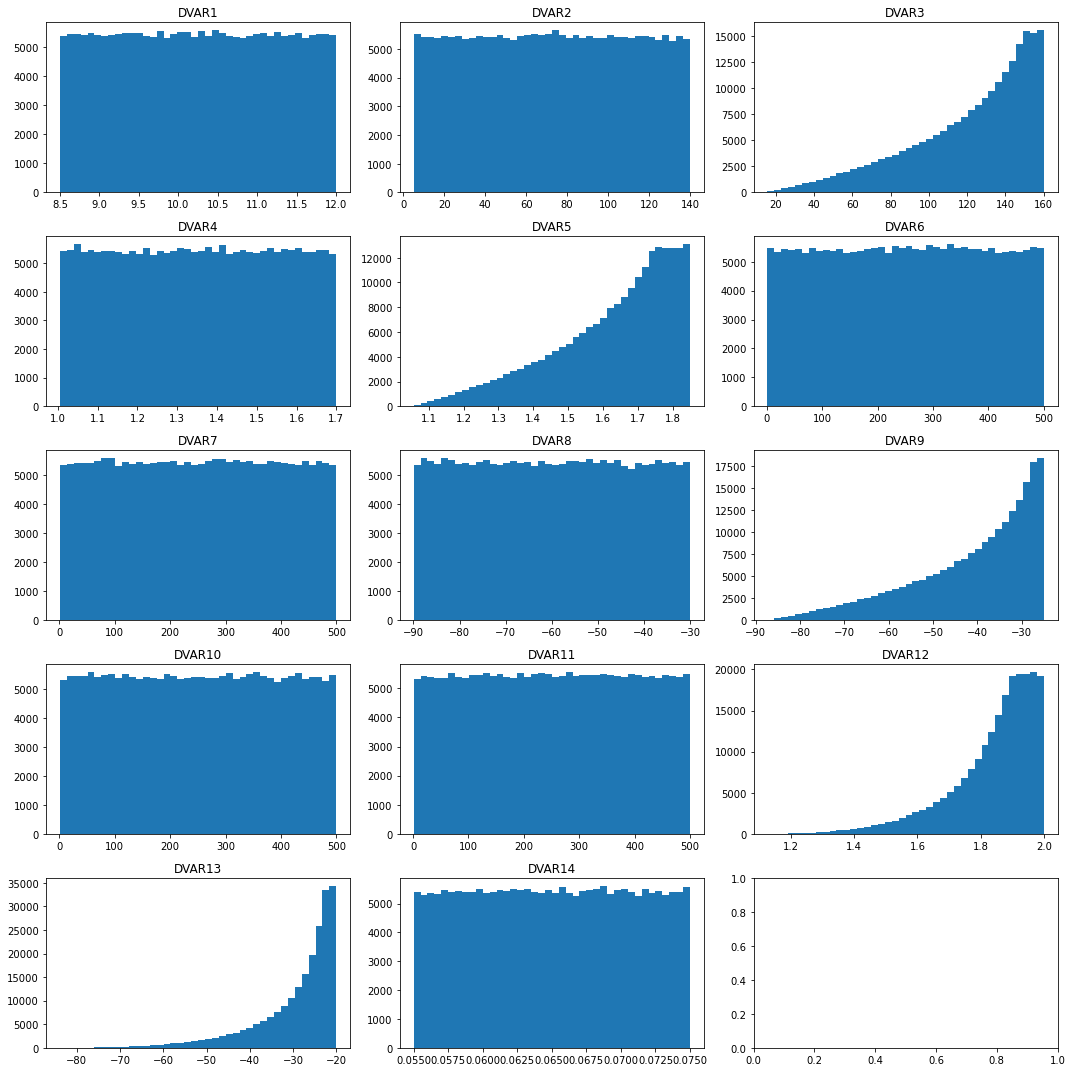

In [12]:
fig, axs = plt.subplots(5, 3, figsize=(15, 15))

for i in range(14):
    ax = axs.flatten()[i]
    ax.hist(x_df[f'DVAR{i+1}'], bins=40)
    ax.set_title(f'DVAR{i+1}')

plt.tight_layout()
plt.show()

In [21]:
minima = {
    'DVAR1': 8.5,
    'DVAR2': 5.,
    'DVAR3': 15.,
    'DVAR4': 1.005,
    'DVAR5': 1.055,
    'DVAR6': 1.,
    'DVAR7': 1.,
    'DVAR8': -89.95,
    'DVAR9': -87.45,
    'DVAR10': 1.,
    'DVAR11': 1.,
    'DVAR12': 1.105,
    'DVAR13': -84.95,
    'DVAR14': 0.055
}

lambdas = {}
boxcox_x_df = pd.DataFrame()

for i in range(14):
    feature_name = f'DVAR{i+1}'
    x_data = x_df[feature_name].values
    if np.min(x_data) < 0:
        x_data = x_data - 1.01*minima[feature_name]
    
    transformed_x, best_lambda = boxcox(x_data)
    lambdas[feature_name] = best_lambda
    boxcox_x_df[feature_name] = transformed_x

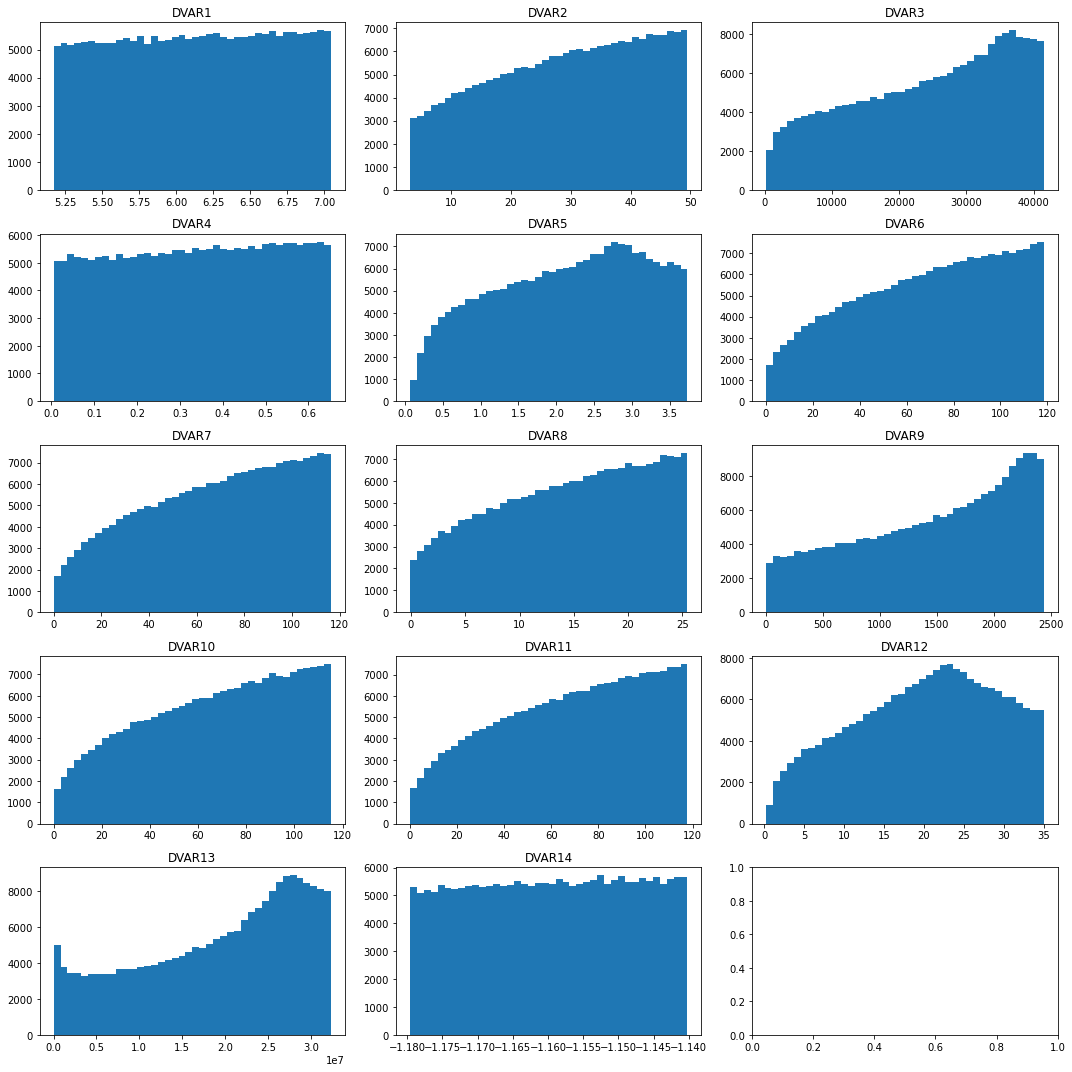

In [22]:
# boxcox transformed data
fig, axs = plt.subplots(5, 3, figsize=(15, 15))

for i in range(14):
    ax = axs.flatten()[i]
    ax.hist(boxcox_x_df[f'DVAR{i+1}'], bins=40)
    ax.set_title(f'DVAR{i+1}')

plt.tight_layout()
plt.show()

In [24]:
# power transform
pt = PowerTransformer()
pt.fit(x_df.values)

powertransform_lambdas = pt.lambdas_

powertransform_x_df = pd.DataFrame(pt.transform(x_df.values), columns=x_df.columns)

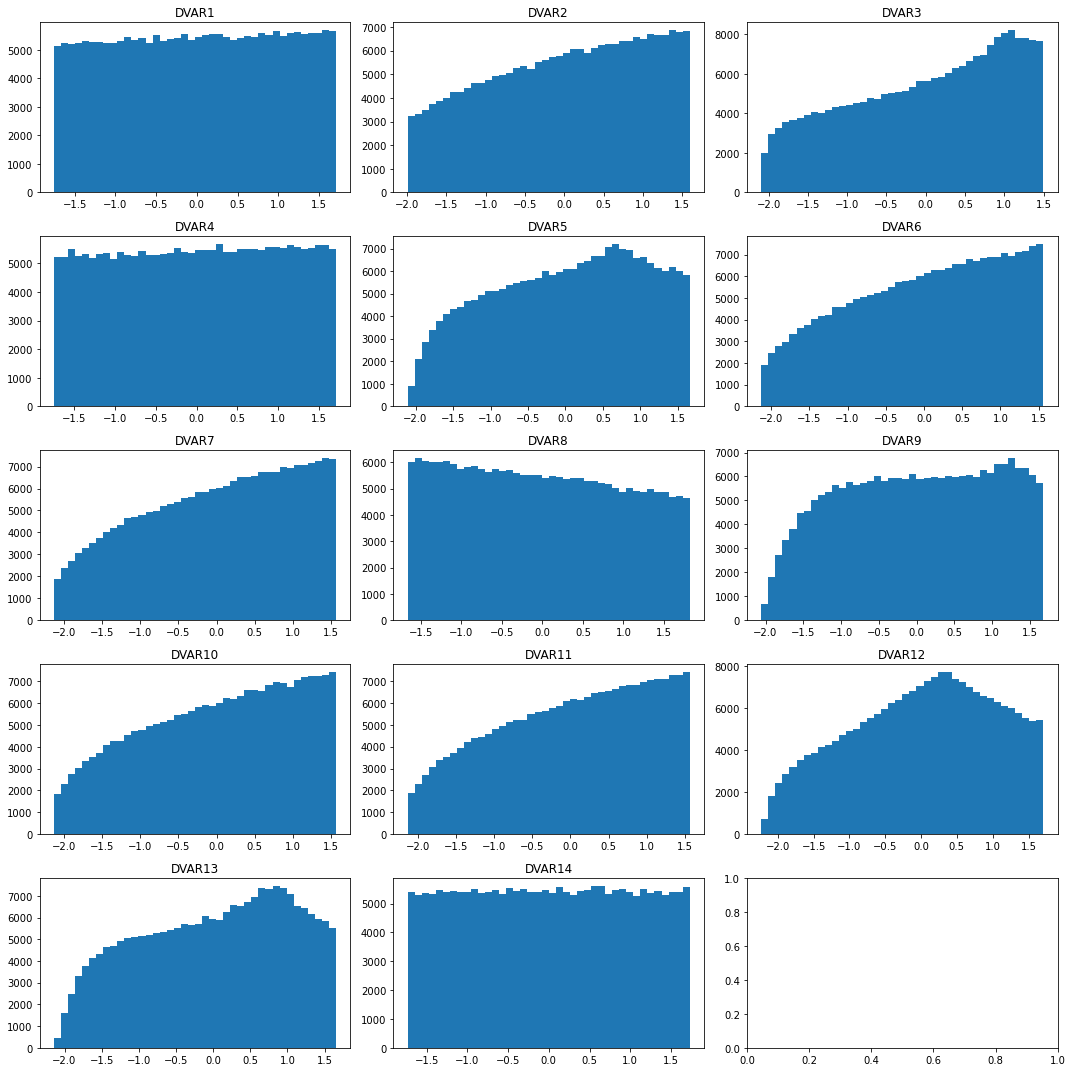

In [27]:
# power transformed data
fig, axs = plt.subplots(5, 3, figsize=(15, 15))

for i in range(14):
    ax = axs.flatten()[i]
    ax.hist(powertransform_x_df[f'DVAR{i+1}'], bins=40)
    ax.set_title(f'DVAR{i+1}')

plt.tight_layout()
plt.show()

In [86]:
# get variable ranges
with open('data/full_opt_15KeV/Full-RFQ-optimization_doc.txt', 'r') as f:
    feature_ranges_raw = []
    for line in f.readlines():
        if line[:4] == 'DVAR' and 'definitions' not in line:
            feature_ranges_raw.append(line.strip())
            
search_results = [re.search(r'\[(.*?)\]', line).group() for line in feature_ranges_raw]

minima = {}
maxima = {}
for i in range(14):
    res = search_results[i]
    minima[f'DVAR{i+1}'] = float(res.split(', ')[0].split(' ')[1])
    maxima[f'DVAR{i+1}'] = float(res.split(', ')[1].split(' ')[0])

In [109]:
x_df.loc[75]

DVAR1      10.56786
DVAR2      21.46115
DVAR3      59.72151
DVAR4       1.51956
DVAR5       1.59233
DVAR6     104.71841
DVAR7     169.58247
DVAR8     -38.00836
DVAR9     -29.05036
DVAR10    232.03329
DVAR11    291.27876
DVAR12      1.78100
DVAR13    -24.92231
DVAR14      0.07500
Name: 75, dtype: float64

In [94]:
# inverse-transform uniform variables
inverse_transform_x_df = pd.DataFrame()

for i in [1, 2, 4, 6, 7, 8, 10, 11, 14]:
    feature_name = f'DVAR{i}'
    transformed_data = norm.ppf(
        (x_df[feature_name].values - minima[feature_name]) / (maxima[feature_name] - minima[feature_name])
    )
    inverse_transform_x_df[feature_name] = transformed_data

In [107]:
inverse_transform_x_df.loc[75]

DVAR1     0.229647
DVAR2    -1.165371
DVAR4     0.644499
DVAR6    -0.813895
DVAR7    -0.418364
DVAR8     1.109608
DVAR10   -0.092897
DVAR11    0.206298
DVAR14         inf
Name: 75, dtype: float64

In [106]:
np.where(inverse_transform_x_df == np.inf)

(array([    75,   1240,   1410,   1413,   4803,   5089,   9851,  10277,
         11787,  15768,  19584,  21754,  22915,  32688,  33299,  35280,
         49510,  53854,  54377,  60383,  64044,  83191,  94308,  95050,
         99335, 100537, 104791, 105243, 110841, 114449, 116097, 119310,
        123957, 126702, 130731, 132590, 150131, 159960, 164961, 167078,
        171505, 175300, 176326, 177387, 177556, 182066, 186220, 186824,
        186936, 199706, 202029, 205766, 205937, 208345, 208641, 209957,
        215130]),
 array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8]))

In [93]:
(x_df[feature_name].values - minima[feature_name]) / (maxima[feature_name] - minima[feature_name])

array([0.1375, 0.9205, 0.569 , ..., 0.3455, 0.4105, 0.794 ])

ValueError: supplied range of [-4.388213201739666, inf] is not finite

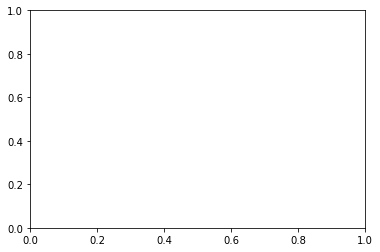

In [99]:
# inverse transformed data
for col in inverse_transform_x_df.columns:
    plt.hist(inverse_transform_x_df[col])